# Blinded analyses
In some studies it becomes necessary to hide the true value of a magnitude in order to prevent analysts to bias the result. The MinKit package offers a way to wrap the values and errors of the parameters to complicate the access to these attributes. Let's start by building a model composed by two components.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import minkit
import numpy as np

m = minkit.Parameter('m', bounds=(0, 40))
c = minkit.Parameter('c', 30, bounds=(10, 40))
s = minkit.Parameter('s', 2, bounds=(1, 4))
a = minkit.Parameter('a', 0.5, bounds=(0.1, 10))
n = minkit.Parameter('n', 4, bounds=(2, 8))

cb = minkit.CrystalBall('sig', m, c, s, a, n)

k = minkit.Parameter('k', -0.01, bounds=(-1, 0))
e = minkit.Exponential('bkg', m, k)

y = minkit.Parameter('y', 0.5, bounds=(0, 1))

pdf = minkit.AddPDFs.two_components('pdf', cb, e, y)

data = pdf.generate(10000)

Now that we have the PDF and a data sample to fit we will blind the parameters ruling the tail of the Crystal-Ball function *a* and *n*.

In [2]:
a.set_blinding_configuration(scale=10, offset=2)
n.set_blinding_configuration(scale=10, offset=3)

The first element of the tuple rules the distance of the *blinded* value to the true value of the parameter. The second is related to a scale factor that multiplies the sum of the two previous quantities. Two random numbers are generated and determine the final equation to transform *true values* into *blinded values*. You can see that both the values and the bounds of the parameters are now modified when we access them:

In [3]:
print(f'(a) value: {a.value}, bounds: {a.bounds}')
print(f'(n) value: {n.value}, bounds: {n.bounds}')

(a) value: 4.916079425426541, bounds: [ 3.36839491 41.67358666]
(n) value: 23.091460187211293, bounds: [11.66798573 45.9384091 ]


Note that from this and from the initial values it is possible to determine the transformation that is used in order to hide the true values. The *blinding* procedure is just a way to avoid looking at the true result before the whole analysis strategy has been defined, and the sensitivities have been computed. We can now run a fit and see the results.

In [4]:
with minkit.minimizer('uml', pdf, data) as minimizer:
    minimizer.minimize()

FCN = 70511.86371752557 
 TOTAL NCALL = 307 
 NCALLS = 307 
 
 
 EDM = 7.65756182914956e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,y,0.492744,0.0220504,,,0,1,No
1,c,30.0094,0.107735,,,10,40,No
2,s,1.98935,0.0945799,,,1,4,No
3,a,4.98843,0.25623,,,3.36839,41.6736,No
4,n,17.9271,7.23937,,,11.668,45.9384,No
5,k,-0.00784277,0.00209144,,,-1,0,No


You can see that in the information displayed by MIGRAD the bounds and values of the parameters are shown blinded. If we attempt to generate or evaluate the PDF on our own, it will be called with the blinded values. In order to retrieve the true result we must remove the configuration of the data parameters, as

In [5]:
a.set_blinding_configuration(None)
print(f'value: {a.value}, error: {a.error}, bounds: {a.bounds}')

value: 0.5186978955912507, error: 0.0662227450698552, bounds: [ 0.1 10. ]


If we want to modify the value of the parameter, either we work with the blinded parameter (thus the provided value must lie within the blinded bounds), or we must unblind it before. In order to have a better control of the *blinding* status of the parameter, it is possible to create a context where the parameter is unblinded. This turns usefull when plotting results, for example:

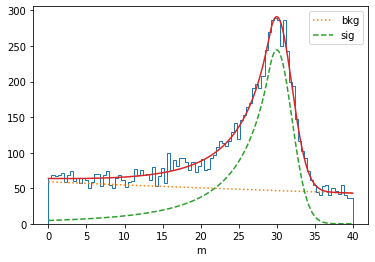

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

with n.blind(status=False): # we disable the blind status
    values, edges = minkit.data_plotting_arrays(data, bins=100)
    centers = 0.5 * (edges[1:] + edges[:-1])
    bkg_x, bkg_y = minkit.pdf_plotting_arrays(pdf, values, edges, component='bkg')
    sig_x, sig_y = minkit.pdf_plotting_arrays(pdf, values, edges, component='sig')
    pdf_x, pdf_y = minkit.pdf_plotting_arrays(pdf, values, edges)
    ax.hist(centers, bins=edges, weights=values, histtype='step')
    ax.plot(bkg_x, bkg_y, ':', label='bkg')
    ax.plot(sig_x, sig_y, '--', label='sig')
    ax.plot(pdf_x, pdf_y, '-')
    ax.set_xlabel('m')
    ax.legend()

We can also calculate asymmetric errors or FCN profiles but, to ensure that the minimum of the parameter remains blinded, the values  to provide must correspond to the *blinded* bounds.

(blind) asymmetric errors: (5.853308311383646, 12.80918951622196)
(unblind) asymmetric errors: (1.0247859938196304, 2.242608335336864)


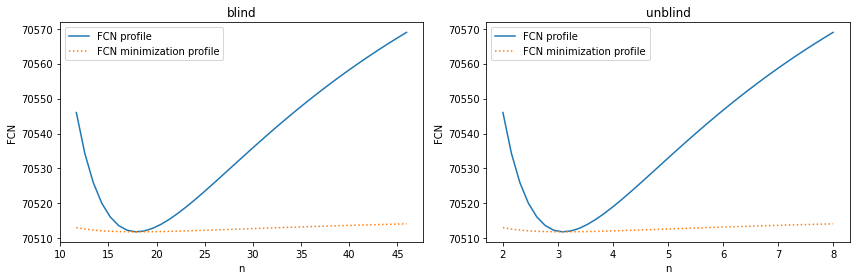

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

with minkit.minimizer('uml', pdf, data) as minimizer:
    
    minimizer.minuit.print_level = 0
    
    minimizer.minimize()
    
    minimizer.asymmetric_errors('n')
    
    print(f'(blind) asymmetric errors: {n.asym_errors}')
    with n.blind(status=False):
        print(f'(unblind) asymmetric errors: {n.asym_errors}')
    
    values = np.linspace(*n.bounds, 40)
    profile = minimizer.fcn_profile('n', values)
    ax0.plot(values, profile, 'C0-', label='FCN profile')
    profile = minimizer.minimization_profile('n', values)
    ax0.plot(values, profile, 'C1:', label='FCN minimization profile')
    ax0.set_title('blind')
    
    with n.blind(status=False):
        values = np.linspace(*n.bounds, 40)
        profile = minimizer.fcn_profile('n', values)
        ax1.plot(values, profile, 'C0-', label='FCN profile')
        profile = minimizer.minimization_profile('n', values)
        ax1.plot(values, profile, 'C1:', label='FCN minimization profile')
        ax1.set_title('unblind')
    
    for ax in (ax0, ax1):
        ax.set_xlabel('n')
        ax.set_ylabel('FCN')
        ax.legend()
        
fig.tight_layout()

In conclusion, operations involving blinded parameters are completely safe as long as the user does not compute the transformation coefficients.

## Blinding based on an offset
It might be of interest to set a blinding method in such a way that the absolute error of the blinded parameter reflects the actual error of the true value. This can only be achieved by applying a blinding transformation based on an offset. As can be checked below, after the fit the two errors for the center of the Gaussian function are exactly the same.

In [8]:
m = minkit.Parameter('m', bounds=(10, 30))
c = minkit.Parameter('c', 15, bounds=(10, 30))
s = minkit.Parameter('s', 2, bounds=(0.5, 4))
pdf = minkit.Gaussian('pdf', m, c, s)

data = pdf.generate(10000)

c.set_blinding_configuration(offset=10)

with minkit.minimizer('uml', pdf, data) as minimizer:
   
    minimizer.minimize()
    
    print(f'(blinded) value: {c.value}, error: {c.error}')
    with c.blind(status=False):
        print(f'(unblinded) value: {c.value}, error: {c.error}')

FCN = 41832.92926167302 
 TOTAL NCALL = 35 
 NCALLS = 35 
 
 
 EDM = 1.3124194912961515e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,c,24.6405,0.0207467,,,19.6135,39.6135,No
1,s,2.01671,0.0156648,,,0.5,4,No


(blinded) value: 24.64045472684576, error: 0.0207466726719705
(unblinded) value: 15.026961133328705, error: 0.0207466726719705


## Blinding based on a scale
Instead of blinding a parameter in such a way that the absolute error remains constant after the transformation, we might be interested on only keeping the relative error. This is achieved by blinding the parameter using a scale factor. In the following example you can see that the relative error for the center remains unchanged.

In [9]:
m = minkit.Parameter('m', bounds=(10, 30))
c = minkit.Parameter('c', 15, bounds=(10, 30))
s = minkit.Parameter('s', 2, bounds=(0.5, 4))
pdf = minkit.Gaussian('pdf', m, c, s)

data = pdf.generate(10000)

c.set_blinding_configuration(scale=10)

with minkit.minimizer('uml', pdf, data) as minimizer:
   
    minimizer.minimize()
    
    print(f'(blinded) value: {c.value}, relative error: {c.error / c.value}')
    with c.blind(status=False):
        print(f'(unblinded) value: {c.value}, relative error: {c.error / c.value}')

FCN = 41446.730162885986 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 1.369451829634696e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,c,134.98,0.182947,,,90.1757,270.527,No
1,s,1.97526,0.0152874,,,0.5,4,No


(blinded) value: 134.9800400379359, relative error: 0.0013553665592806795
(unblinded) value: 14.96855217177077, relative error: 0.0013553665592806795
